# Time-Series Clustering with Pretrained Models

This notebook demonstrates clustering of time-series data using pretrained models and specialized time-series distance metrics. We'll use TSLearn library which provides tools specifically designed for time-series clustering.

**Objective**: Apply time-series specific clustering algorithms to group similar temporal patterns using Dynamic Time Warping (DTW) and other time-aware distance metrics.

In [1]:
# Installing required libraries
!pip install tslearn scikit-learn matplotlib seaborn pandas numpy -q

# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

# Setting style
sns.set_style("whitegrid")
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 8.4 MB/s eta 0:00:00


## Loading Time-Series Data

Loading the UCR Time Series Archive Trace dataset which contains electrical power demand recordings. This is a classic time-series classification dataset that we'll use for unsupervised clustering.

Data shape: (200, 275, 1)
Number of time series: 200
Length of each series: 275
Number of features: 1
Number of classes in original data: 4


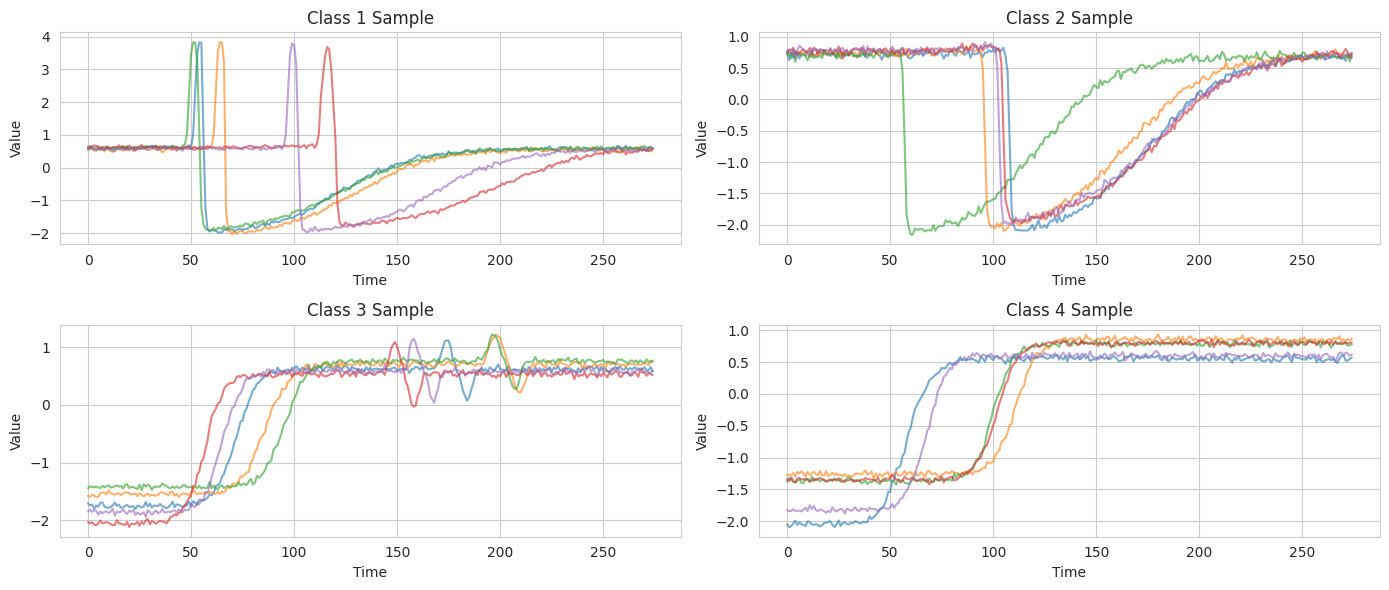

In [2]:
# Loading Trace dataset from TSLearn's cached datasets
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

# Combining train and test for clustering (unsupervised)
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

print(f"Data shape: {X.shape}")
print(f"Number of time series: {X.shape[0]}")
print(f"Length of each series: {X.shape[1]}")
print(f"Number of features: {X.shape[2]}")
print(f"Number of classes in original data: {len(np.unique(y))}")

# Visualizing sample time series from different classes
plt.figure(figsize=(14, 6))
for yi in np.unique(y):
    plt.subplot(2, 2, int(yi))
    for xx in X[y == yi][:5]:
        plt.plot(xx.ravel(), alpha=0.6)
    plt.title(f"Class {int(yi)} Sample", fontsize=12)
    plt.xlabel("Time")
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

## Preprocessing Time-Series Data

Normalizing time series to have zero mean and unit variance to ensure fair comparison across series with different scales.

Scaled data shape: (200, 275, 1)
Mean of scaled data: -0.0000
Std of scaled data: 1.0000


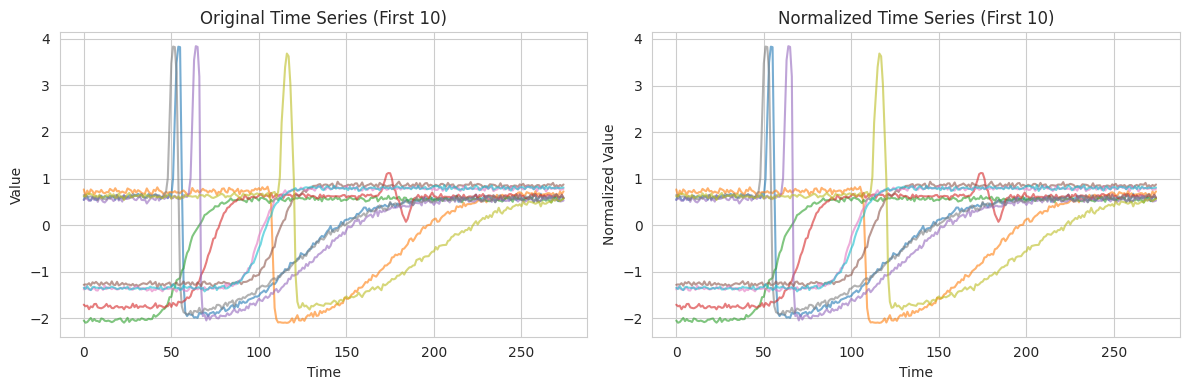

In [3]:
# Normalizing time series data
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean of scaled data: {X_scaled.mean():.4f}")
print(f"Std of scaled data: {X_scaled.std():.4f}")

# Visualizing normalized series
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for i in range(10):
    plt.plot(X[i].ravel(), alpha=0.6)
plt.title("Original Time Series (First 10)", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(X_scaled[i].ravel(), alpha=0.6)
plt.title("Normalized Time Series (First 10)", fontsize=12)
plt.xlabel("Time")
plt.ylabel("Normalized Value")

plt.tight_layout()
plt.show()

## Time-Series Clustering with Dynamic Time Warping (DTW)

Applying K-Means clustering using Dynamic Time Warping (DTW) as the distance metric. DTW handles time series that may be shifted or stretched in time, making it superior to Euclidean distance for temporal data.

In [4]:
# Clustering with DTW metric
n_clusters = 4

print("Training Time-Series K-Means with DTW metric...")
dtw_model = TimeSeriesKMeans(n_clusters=n_clusters,
                             metric="dtw",
                             max_iter=10,
                             random_state=42,
                             n_jobs=-1,
                             verbose=False)

dtw_labels = dtw_model.fit_predict(X_scaled)

print(f"\n{'='*50}")
print(f"Time-Series K-Means with DTW Results")
print(f"{'='*50}")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution: {np.bincount(dtw_labels)}")
print(f"Inertia: {dtw_model.inertia_:.2f}")

# Calculating Adjusted Rand Index (comparing with true labels)
ari_dtw = adjusted_rand_score(y, dtw_labels)
print(f"Adjusted Rand Index: {ari_dtw:.3f}")

Training Time-Series K-Means with DTW metric...

Time-Series K-Means with DTW Results
Number of clusters: 4
Cluster distribution: [39 50 50 61]
Inertia: 0.50
Adjusted Rand Index: 0.664


## Clustering with Euclidean Distance (For Comparison)

Applying standard K-Means with Euclidean distance to compare with DTW-based clustering. This helps demonstrate why specialized time-series metrics are important.

In [5]:
# Clustering with Euclidean metric for comparison
print("Training Time-Series K-Means with Euclidean metric...")
euclidean_model = TimeSeriesKMeans(n_clusters=n_clusters,
                                   metric="euclidean",
                                   max_iter=10,
                                   random_state=42,
                                   n_jobs=-1,
                                   verbose=False)

euclidean_labels = euclidean_model.fit_predict(X_scaled)

print(f"\n{'='*50}")
print(f"Time-Series K-Means with Euclidean Results")
print(f"{'='*50}")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution: {np.bincount(euclidean_labels)}")
print(f"Inertia: {euclidean_model.inertia_:.2f}")

# Calculating Adjusted Rand Index
ari_euclidean = adjusted_rand_score(y, euclidean_labels)
print(f"Adjusted Rand Index: {ari_euclidean:.3f}")

# Comparing metrics
print(f"\n{'='*50}")
print(f"Comparison: DTW vs Euclidean")
print(f"{'='*50}")
print(f"DTW ARI: {ari_dtw:.3f}")
print(f"Euclidean ARI: {ari_euclidean:.3f}")
print(f"Winner: {'DTW' if ari_dtw > ari_euclidean else 'Euclidean'}")

Training Time-Series K-Means with Euclidean metric...

Time-Series K-Means with Euclidean Results
Number of clusters: 4
Cluster distribution: [55 51 45 49]
Inertia: 40.93
Adjusted Rand Index: 0.328

Comparison: DTW vs Euclidean
DTW ARI: 0.664
Euclidean ARI: 0.328
Winner: DTW


## Visualizing Cluster Centers (Prototypes)

Plotting the learned cluster centers from both DTW and Euclidean methods. These represent the "typical" time series pattern for each cluster.

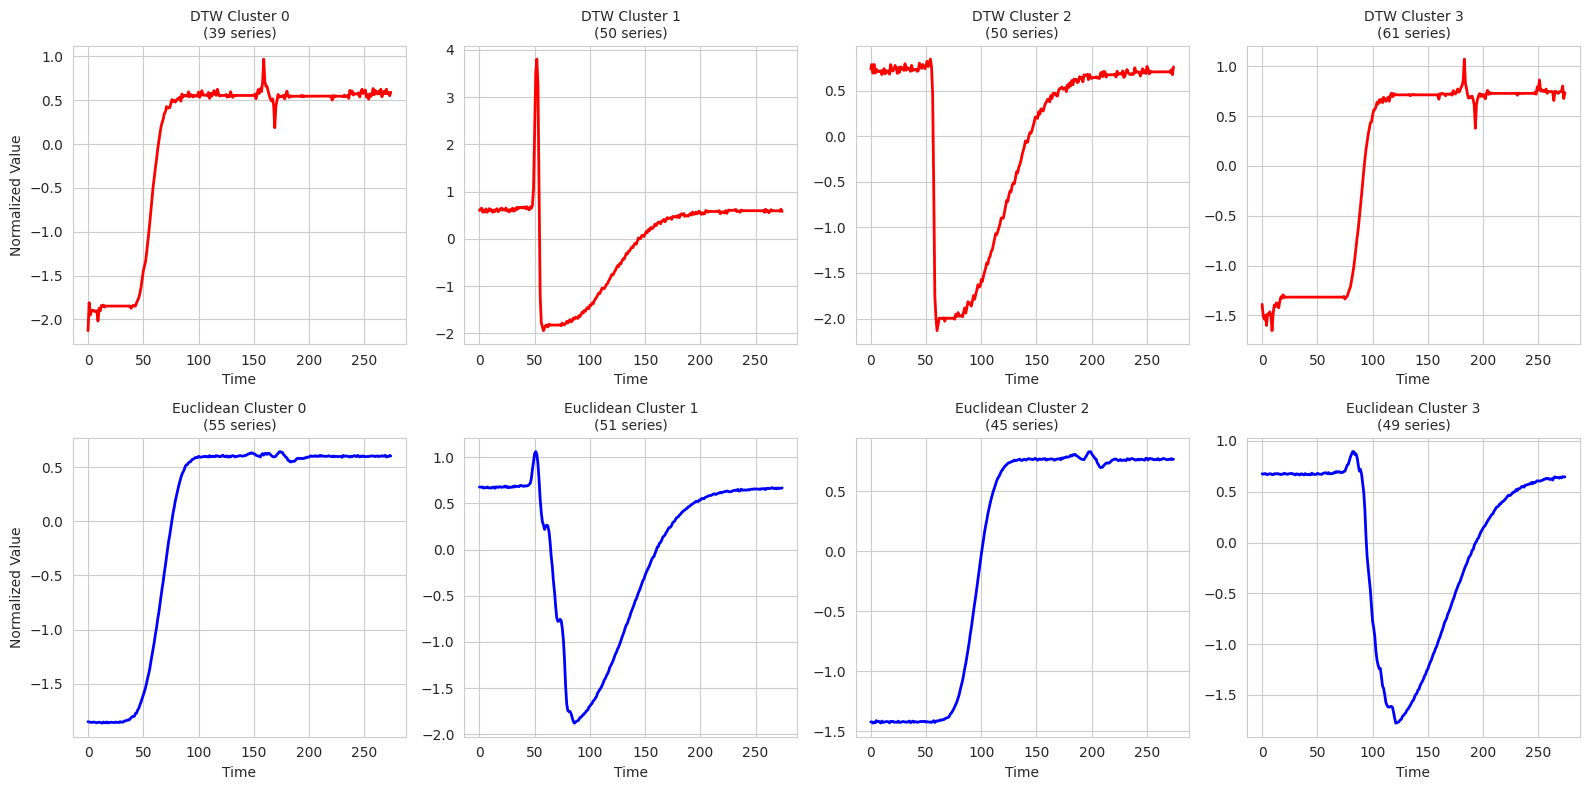

In [6]:
# Visualizing cluster centers
fig, axes = plt.subplots(2, n_clusters, figsize=(16, 8))

# DTW cluster centers
for i in range(n_clusters):
    axes[0, i].plot(dtw_model.cluster_centers_[i].ravel(), linewidth=2, color='red')
    axes[0, i].set_title(f"DTW Cluster {i}\n({np.sum(dtw_labels == i)} series)", fontsize=10)
    axes[0, i].set_xlabel("Time")
    if i == 0:
        axes[0, i].set_ylabel("Normalized Value")

# Euclidean cluster centers
for i in range(n_clusters):
    axes[1, i].plot(euclidean_model.cluster_centers_[i].ravel(), linewidth=2, color='blue')
    axes[1, i].set_title(f"Euclidean Cluster {i}\n({np.sum(euclidean_labels == i)} series)", fontsize=10)
    axes[1, i].set_xlabel("Time")
    if i == 0:
        axes[1, i].set_ylabel("Normalized Value")

plt.tight_layout()
plt.show()

## Visualizing Sample Series from Each Cluster

Displaying representative time series from each cluster to understand the temporal patterns captured by the DTW-based clustering.

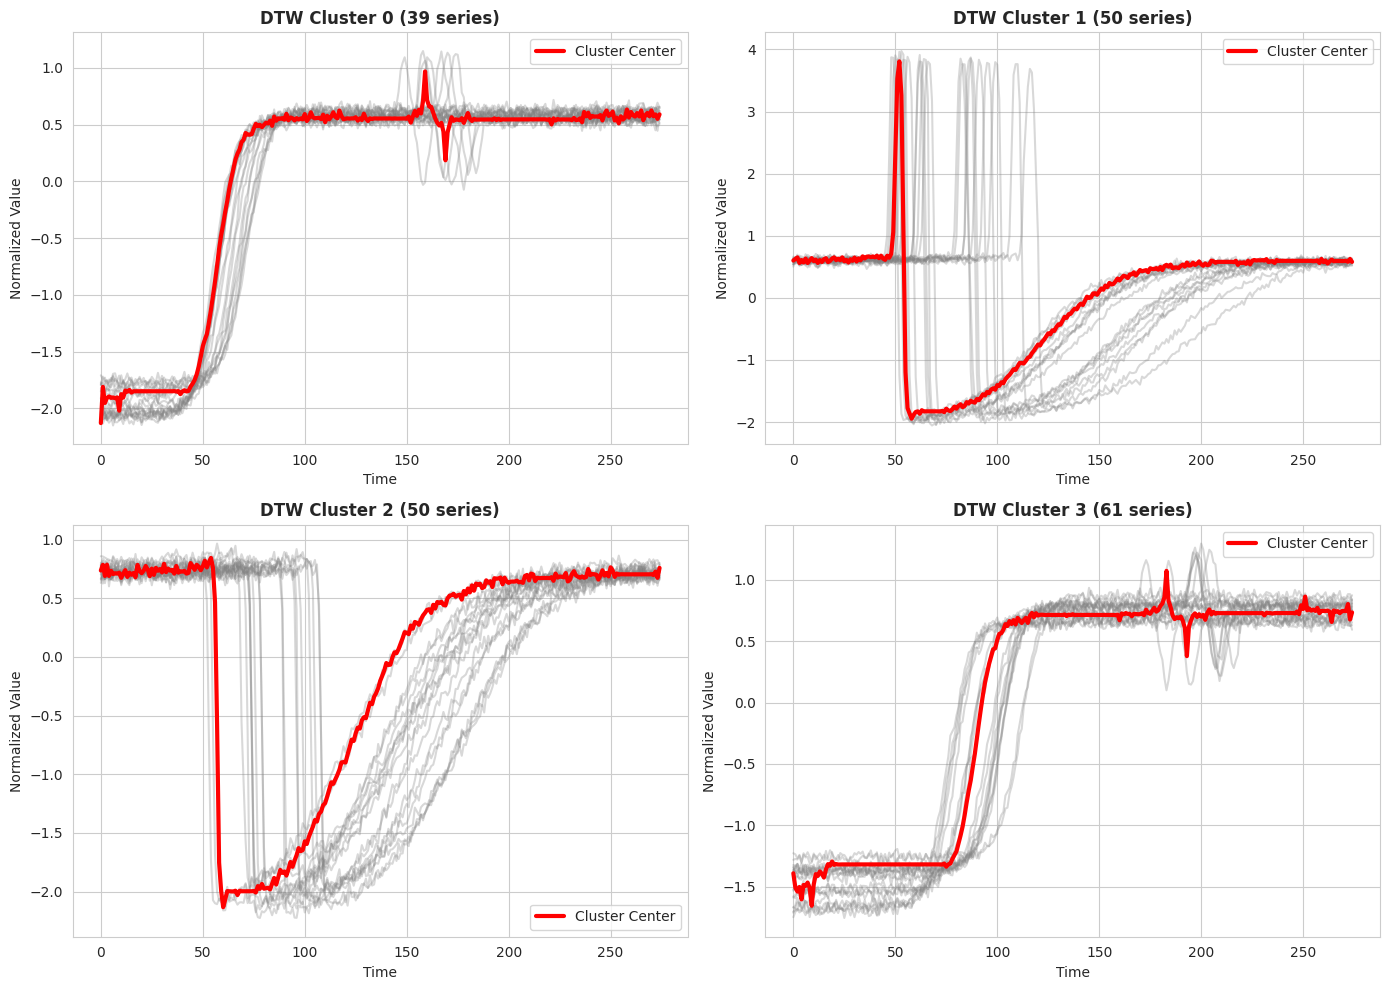

In [7]:
# Visualizing sample series from each DTW cluster
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for cluster_id in range(n_clusters):
    cluster_data = X_scaled[dtw_labels == cluster_id]

    # Plotting up to 20 series from this cluster
    for series in cluster_data[:20]:
        axes[cluster_id].plot(series.ravel(), alpha=0.3, color='gray')

    # Plotting cluster center in bold
    axes[cluster_id].plot(dtw_model.cluster_centers_[cluster_id].ravel(),
                         linewidth=3, color='red', label='Cluster Center')

    axes[cluster_id].set_title(f"DTW Cluster {cluster_id} ({len(cluster_data)} series)",
                              fontsize=12, fontweight='bold')
    axes[cluster_id].set_xlabel("Time")
    axes[cluster_id].set_ylabel("Normalized Value")
    axes[cluster_id].legend()

plt.tight_layout()
plt.show()

## Confusion Matrix: Predicted vs True Labels

Comparing the clustering results with the original class labels to evaluate how well the unsupervised clustering recovered the true structure.

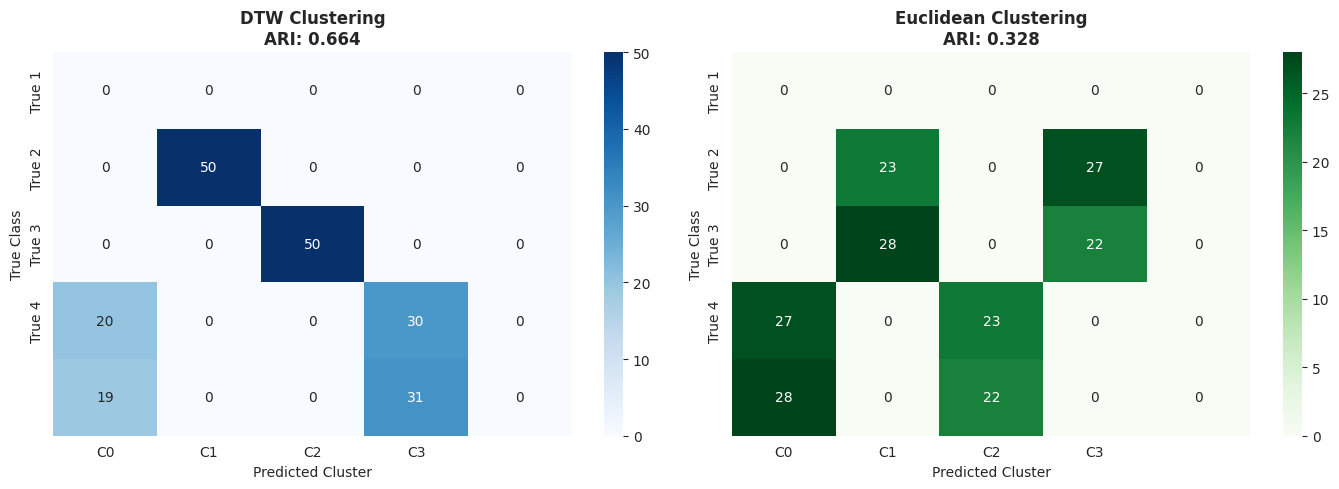


Time-series clustering complete!
DTW-based clustering achieved ARI of 0.664
Euclidean-based clustering achieved ARI of 0.328


In [8]:
# Creating confusion matrices
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DTW confusion matrix
cm_dtw = confusion_matrix(y, dtw_labels)
sns.heatmap(cm_dtw, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[f'C{i}' for i in range(n_clusters)],
            yticklabels=[f'True {i}' for i in range(1, 5)])
axes[0].set_title(f'DTW Clustering\nARI: {ari_dtw:.3f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Cluster')
axes[0].set_ylabel('True Class')

# Euclidean confusion matrix
cm_euclidean = confusion_matrix(y, euclidean_labels)
sns.heatmap(cm_euclidean, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[f'C{i}' for i in range(n_clusters)],
            yticklabels=[f'True {i}' for i in range(1, 5)])
axes[1].set_title(f'Euclidean Clustering\nARI: {ari_euclidean:.3f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Cluster')
axes[1].set_ylabel('True Class')

plt.tight_layout()
plt.show()

print(f"\nTime-series clustering complete!")
print(f"DTW-based clustering achieved ARI of {ari_dtw:.3f}")
print(f"Euclidean-based clustering achieved ARI of {ari_euclidean:.3f}")